In [8]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 1
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

In [9]:
!ls ../input

test_v2  train_ship_segmentations_v2.csv  train_v2


In [10]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../input'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')
import gc; gc.enable() # memory is tight

from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [11]:
masks = pd.read_csv(os.path.join('../input/',
                                 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


# Split Training and Validation sets

,ImageId,ships,has_ship,has_ship_vec,file_size_kb
188600,fad69cb70.jpg,0,0.0,[0.0],160.246094
21311,1c52d83e0.jpg,0,0.0,[0.0],121.658203
47940,3ff56a64e.jpg,0,0.0,[0.0],204.791016
87868,749b518d3.jpg,0,0.0,[0.0],162.068359
149396,c6b48a312.jpg,0,0.0,[0.0],163.541992


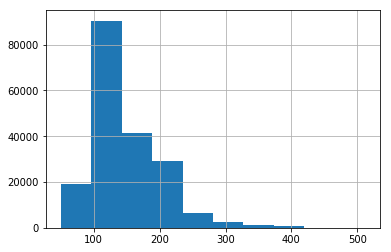

In [12]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, 
                                                                                    c_img_id)).st_size/1024)
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files
unique_img_ids['file_size_kb'].hist()
masks.drop(['ships'], axis=1, inplace=True)
unique_img_ids.sample(5)

In [13]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

161048 training masks
69034 validation masks


## Number of Ships

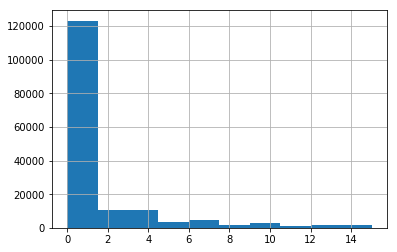

In [14]:
train_df['ships'].hist()

## Undersample Empty Images

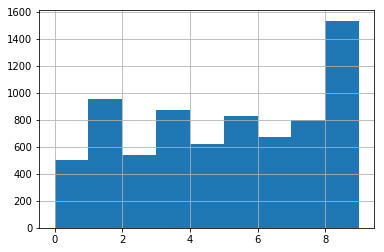

In [15]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))

## Decode all the RLEs into images
* make a generator to produce batches of images

In [16]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)
            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [17]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def m

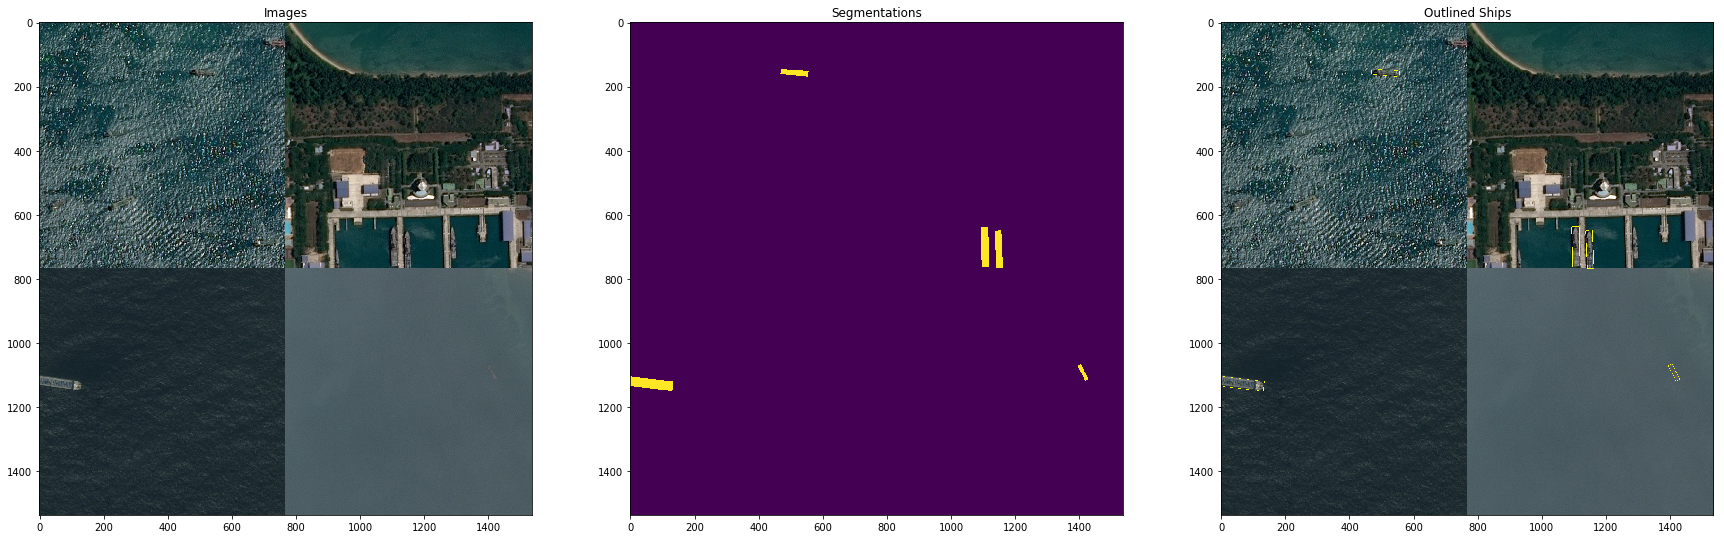

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('overview.png')

## Make Validation Set

In [19]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


## Augment Data - Skip for now

In [4]:
import tensorflow as tf

In [1]:
def conv2d(input_tensor, depth, kernel, name, strides=(1, 1), padding="SAME"):
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=tf.nn.relu, name=name)

In [2]:
def deconv2d(input_tensor, filter_size, output_size, out_channels, in_channels, name, strides = [1, 1, 1, 1]):
    dyn_input_shape = tf.shape(input_tensor)
    batch_size = dyn_input_shape[0]
    out_shape = tf.stack([batch_size, output_size, output_size, out_channels])
    filter_shape = [filter_size, filter_size, out_channels, in_channels]
    w = tf.get_variable(name=name, shape=filter_shape)
    h1 = tf.nn.conv2d_transpose(input_tensor, w, out_shape, strides, padding='SAME')
    return h1

In [5]:
X = tf.placeholder(tf.float32, [None, 768, 768, 3])
Y_ = tf.placeholder(tf.float32, [None, 768, 768, 1])
lr = tf.placeholder(tf.float32)

In [7]:
net = conv2d(X, 32, 1, "Y0") #128

net = conv2d(net, 64, 3, "Y2", strides=(2, 2)) #64

net = conv2d(net, 128, 3, "Y3", strides=(2, 2)) #32


net = deconv2d(net, 1, 32, 768, 768, "Y2_deconv") # 32
net = tf.nn.relu(net)

net = deconv2d(net, 2, 389, 389, 768, "Y1_deconv", strides=[1, 2, 2, 1]) # 64
net = tf.nn.relu(net)

net = deconv2d(net, 2, 768, 32, 64, "Y0_deconv", strides=[1, 2, 2, 1]) # 128
net = tf.nn.relu(net)

logits = deconv2d(net, 1, 768, 1, 32, "logits_deconv") # 128

loss = tf.losses.sigmoid_cross_entropy(Y_, logits)
optimizer = tf.train.AdamOptimizer(lr).minimize(loss)

ValueError: Variable Y0/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "<ipython-input-1-d1e26f9169f7>", line 2, in conv2d
    return tf.layers.conv2d(input_tensor, filters=depth, kernel_size=kernel, strides=strides, padding=padding, activation=tf.nn.relu, name=name)
  File "<ipython-input-6-eb6c00967792>", line 1, in <module>
    net = conv2d(X, 32, 1, "Y0") #128
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 3265, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)


## Models

In [24]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/usr/local/lib/python3.6/dist-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def m

Text(0.5, 1.0, 'ships')

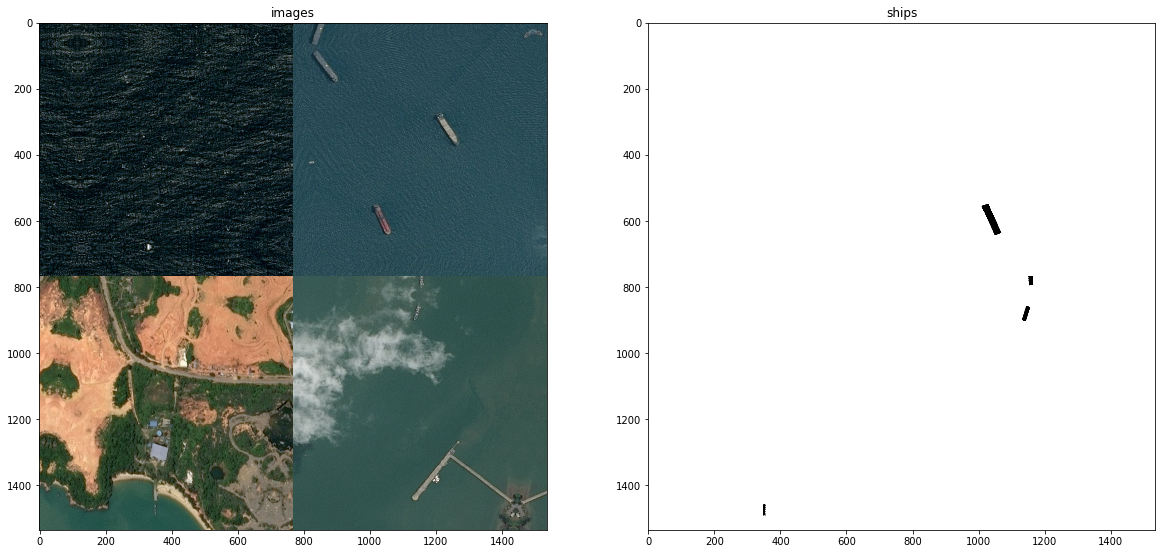

In [25]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [26]:
from keras import models, layers
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple
    
input_img = layers.Input(t_x.shape[1:], name = 'RGB_Input')
pp_in_layer = input_img
if NET_SCALING is not None:
    pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
    
pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
pp_in_layer = layers.BatchNormalization()(pp_in_layer)

c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (pp_in_layer)
c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = layers.MaxPooling2D((2, 2)) (c1)

c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = layers.MaxPooling2D((2, 2)) (c2)

c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = layers.MaxPooling2D((2, 2)) (c3)

c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = layers.Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = layers.concatenate([u6, c4])
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = layers.Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = layers.concatenate([u7, c3])
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = layers.Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = layers.concatenate([u8, c2])
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = layers.Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = layers.concatenate([u9, c1], axis=3)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = layers.Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP))(d)
if NET_SCALING is not None:
    d = layers.UpSampling2D(NET_SCALING)(d)

seg_model = models.Model(inputs=[input_img], outputs=[d])
seg_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          (None, 768, 768, 3)  0                                            
__________________________________________________________________________________________________
gaussian_noise_1 (GaussianNoise (None, 768, 768, 3)  0           RGB_Input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 768, 768, 3)  12          gaussian_noise_1[0][0]           
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 768, 768, 8)  224         batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [27]:
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)
def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)
def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [28]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [31]:
step_count = min(MAX_TRAIN_STEPS, balanced_train_df.shape[0]//BATCH_SIZE)
aug_gen = create_aug_gen(make_image_gen(balanced_train_df))
loss_history = [seg_model.fit_generator(aug_gen, 
                             steps_per_epoch=step_count, 
                             epochs=NB_EPOCHS, 
                             validation_data=(valid_x, valid_y),
                             callbacks=callbacks_list,
                            workers=1 # the generator is not very thread safe
                                       )]

Epoch 1/1
 29/200 [===>..........................] - ETA: 22:43 - loss: -0.0069 - dice_coef: 0.0075 - binary_accuracy: 0.9641 - true_positive_rate: 0.0340

KeyboardInterrupt: 

In [ ]:
def show_loss(loss_history):
    epich = np.cumsum(np.concatenate(
        [np.linspace(0.5, 1, len(mh.epoch)) for mh in loss_history]))
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(22, 10))
    _ = ax1.plot(epich,
                 np.concatenate([mh.history['loss'] for mh in loss_history]),
                 'b-',
                 epich, np.concatenate(
            [mh.history['val_loss'] for mh in loss_history]), 'r-')
    ax1.legend(['Training', 'Validation'])
    ax1.set_title('Loss')

    _ = ax2.plot(epich, np.concatenate(
        [mh.history['true_positive_rate'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_true_positive_rate'] for mh in loss_history]),
                     'r-')
    ax2.legend(['Training', 'Validation'])
    ax2.set_title('True Positive Rate\n(Positive Accuracy)')
    
    _ = ax3.plot(epich, np.concatenate(
        [mh.history['binary_accuracy'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_binary_accuracy'] for mh in loss_history]),
                     'r-')
    ax3.legend(['Training', 'Validation'])
    ax3.set_title('Binary Accuracy (%)')
    
    _ = ax4.plot(epich, np.concatenate(
        [mh.history['dice_coef'] for mh in loss_history]), 'b-',
                     epich, np.concatenate(
            [mh.history['val_dice_coef'] for mh in loss_history]),
                     'r-')
    ax4.legend(['Training', 'Validation'])
    ax4.set_title('DICE')

show_loss(loss_history)

In [ ]:
inputs = Input((768, 768, 3))

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(64, (3, 3), activation='relu', padding='same') (c2)

u3 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c2)
u5 = concatenate([u5, c1])


In [18]:
"""
import tensorflow as tf

def weight_variable(shape, stddev=0.1, name="weight"):
    initial = tf.truncated_normal(shape, stddev=stddev)
    return tf.Variable(initial, name=name)

def weight_variable_devonc(shape, stddev=0.1, name="weight_devonc"):
    return tf.Variable(tf.truncated_normal(shape, stddev=stddev), name=name)

def bias_variable(shape, name="bias"):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W, b, keep_prob_):
    with tf.name_scope("conv2d"):
        conv_2d = tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')
        conv_2d_b = tf.nn.bias_add(conv_2d, b)
        return tf.nn.dropout(conv_2d_b, keep_prob_)

def deconv2d(x, W,stride):
    with tf.name_scope("deconv2d"):
        x_shape = tf.shape(x)
        output_shape = tf.stack([x_shape[0], x_shape[1]*2, x_shape[2]*2, x_shape[3]//2])
        return tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding='VALID', name="conv2d_transpose")

def max_pool(x,n):
    return tf.nn.max_pool(x, ksize=[1, n, n, 1], strides=[1, n, n, 1], padding='VALID')

def crop_and_concat(x1,x2):
    with tf.name_scope("crop_and_concat"):
        x1_shape = tf.shape(x1)
        x2_shape = tf.shape(x2)
        # offsets for the top left corner of the crop
        offsets = [0, (x1_shape[1] - x2_shape[1]) // 2, (x1_shape[2] - x2_shape[2]) // 2, 0]
        size = [-1, x2_shape[1], x2_shape[2], -1]
        x1_crop = tf.slice(x1, offsets, size)
        return tf.concat([x1_crop, x2], 3)

def pixel_wise_softmax(output_map):
    with tf.name_scope("pixel_wise_softmax"):
        max_axis = tf.reduce_max(output_map, axis=3, keepdims=True)
        exponential_map = tf.exp(output_map - max_axis)
        normalize = tf.reduce_sum(exponential_map, axis=3, keepdims=True)
        return exponential_map / normalize

def cross_entropy(y_,output_map):
    return -tf.reduce_mean(y_*tf.log(tf.clip_by_value(output_map,1e-10,1.0)), name="cross_entropy")
"""

In [21]:
"""

import time
import os
import pandas as pd
import tensorflow as tf


def image_augmentation(image, mask):
    """Returns (maybe) augmented images
    (1) Random flip (left <--> right)
    (2) Random flip (up <--> down)
    (3) Random brightness
    (4) Random hue
    Args:
        image (3-D Tensor): Image tensor of (H, W, C)
        mask (3-D Tensor): Mask image tensor of (H, W, 1)
    Returns:
        image: Maybe augmented image (same shape as input `image`)
        mask: Maybe augmented mask (same shape as input `mask`)
    """
    concat_image = tf.concat([image, mask], axis=-1)

    maybe_flipped = tf.image.random_flip_left_right(concat_image)
    maybe_flipped = tf.image.random_flip_up_down(concat_image)

    image = maybe_flipped[:, :, :-1]
    mask = maybe_flipped[:, :, -1:]

    image = tf.image.random_brightness(image, 0.7)
    image = tf.image.random_hue(image, 0.3)

    return image, mask


def get_image_mask(queue, augmentation=True):
    """Returns `image` and `mask`
    Input pipeline:
        Queue -> CSV -> FileRead -> Decode JPEG
    (1) Queue contains a CSV filename
    (2) Text Reader opens the CSV
        CSV file contains two columns
        ["path/to/image.jpg", "path/to/mask.jpg"]
    (3) File Reader opens both files
    (4) Decode JPEG to tensors
    Notes:
        height, width = 768, 768
    Returns
        image (3-D Tensor): (768, 768, 3)
        mask (3-D Tensor): (768, 768, 1)
    """
    text_reader = tf.TextLineReader(skip_header_lines=1)
    _, csv_content = text_reader.read(queue)

    image_path, mask_path = tf.decode_csv(
        csv_content, record_defaults=[[""], [""]])

    image_file = tf.read_file(image_path)
    mask_file = tf.read_file(mask_path)

    image = tf.image.decode_jpeg(image_file, channels=3)
    image.set_shape([768, 768, 3])
    image = tf.cast(image, tf.float32)

    mask = tf.image.decode_jpeg(mask_file, channels=1)
    mask.set_shape([768, 768, 1])
    mask = tf.cast(mask, tf.float32)
    mask = mask / (tf.reduce_max(mask) + 1e-7)

    if augmentation:
        image, mask = image_augmentation(image, mask)

    return image, mask


def conv_conv_pool(input_,
                   n_filters,
                   training,
                   flags,
                   name,
                   pool=True,
                   activation=tf.nn.relu):
    """{Conv -> BN -> RELU}x2 -> {Pool, optional}
    Args:
        input_ (4-D Tensor): (batch_size, H, W, C)
        n_filters (list): number of filters [int, int]
        training (1-D Tensor): Boolean Tensor
        name (str): name postfix
        pool (bool): If True, MaxPool2D
        activation: Activaion functions
    Returns:
        net: output of the Convolution operations
        pool (optional): output of the max pooling operations
    """
    net = input_

    with tf.variable_scope("layer{}".format(name)):
        for i, F in enumerate(n_filters):
            net = tf.layers.conv2d(
                net,
                F, (3, 3),
                activation=None,
                padding='same',
                kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
                name="conv_{}".format(i + 1))
            net = tf.layers.batch_normalization(
                net, training=training, name="bn_{}".format(i + 1))
            net = activation(net, name="relu{}_{}".format(name, i + 1))

        if pool is False:
            return net

        pool = tf.layers.max_pooling2d(
            net, (2, 2), strides=(2, 2), name="pool_{}".format(name))

        return net, pool


def upconv_concat(inputA, input_B, n_filter, flags, name):
    """Upsample `inputA` and concat with `input_B`
    Args:
        input_A (4-D Tensor): (N, H, W, C)
        input_B (4-D Tensor): (N, 2*H, 2*H, C2)
        name (str): name of the concat operation
    Returns:
        output (4-D Tensor): (N, 2*H, 2*W, C + C2)
    """
    up_conv = upconv_2D(inputA, n_filter, flags, name)

    return tf.concat(
        [up_conv, input_B], axis=-1, name="concat_{}".format(name))


def upconv_2D(tensor, n_filter, flags, name):
    """Up Convolution `tensor` by 2 times
    Args:
        tensor (4-D Tensor): (N, H, W, C)
        n_filter (int): Filter Size
        name (str): name of upsampling operations
    Returns:57
        output (4-D Tensor): (N, 2 * H, 2 * W, C)
    """

    return tf.layers.conv2d_transpose(
        tensor,
        filters=n_filter,
        kernel_size=2,
        strides=2,
        kernel_regularizer=tf.contrib.layers.l2_regularizer(flags.reg),
        name="upsample_{}".format(name))


def make_unet(X, training, flags=None):
    """Build a U-Net architecture
    Args:
        X (4-D Tensor): (N, H, W, C)
        training (1-D Tensor): Boolean Tensor is required for batchnormalization layers
    Returns:
        output (4-D Tensor): (N, H, W, C)
            Same shape as the `input` tensor
    Notes:
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        https://arxiv.org/abs/1505.04597
    """
    net = X / 127.5 - 1
    conv1, pool1 = conv_conv_pool(net, [8, 8], training, flags, name=1)
    conv2, pool2 = conv_conv_pool(pool1, [16, 16], training, flags, name=2)
    conv3, pool3 = conv_conv_pool(pool2, [32, 32], training, flags, name=3)
    conv4, pool4 = conv_conv_pool(pool3, [64, 64], training, flags, name=4)
    conv5 = conv_conv_pool(
        pool4, [128, 128], training, flags, name=5, pool=False)

    up6 = upconv_concat(conv5, conv4, 64, flags, name=6)
    conv6 = conv_conv_pool(up6, [64, 64], training, flags, name=6, pool=False)

    up7 = upconv_concat(conv6, conv3, 32, flags, name=7)
    conv7 = conv_conv_pool(up7, [32, 32], training, flags, name=7, pool=False)

    up8 = upconv_concat(conv7, conv2, 16, flags, name=8)
    conv8 = conv_conv_pool(up8, [16, 16], training, flags, name=8, pool=False)

    up9 = upconv_concat(conv8, conv1, 8, flags, name=9)
    conv9 = conv_conv_pool(up9, [8, 8], training, flags, name=9, pool=False)

    return tf.layers.conv2d(
        conv9,
        1, (1, 1),
        name='final',
        activation=tf.nn.sigmoid,
        padding='same')


def IOU_(y_pred, y_true):
    """Returns a (approx) IOU score
    intesection = y_pred.flatten() * y_true.flatten()
    Then, IOU = 2 * intersection / (y_pred.sum() + y_true.sum() + 1e-7) + 1e-7
    Args:
        y_pred (4-D array): (N, H, W, 1)
        y_true (4-D array): (N, H, W, 1)
    Returns:
        float: IOU score
    """
    H, W, _ = y_pred.get_shape().as_list()[1:]

    pred_flat = tf.reshape(y_pred, [-1, H * W])
    true_flat = tf.reshape(y_true, [-1, H * W])

    intersection = 2 * tf.reduce_sum(pred_flat * true_flat, axis=1) + 1e-7
    denominator = tf.reduce_sum(
        pred_flat, axis=1) + tf.reduce_sum(
            true_flat, axis=1) + 1e-7

    return tf.reduce_mean(intersection / denominator)


def make_train_op(y_pred, y_true):
    """Returns a training operation
    Loss function = - IOU(y_pred, y_true)
    IOU is
        (the area of intersection)
        --------------------------
        (the area of two boxes)
    Args:
        y_pred (4-D Tensor): (N, H, W, 1)
        y_true (4-D Tensor): (N, H, W, 1)
    Returns:
        train_op: minimize operation
    """
    loss = -IOU_(y_pred, y_true)

    global_step = tf.train.get_or_create_global_step()

    optim = tf.train.AdamOptimizer()
    return optim.minimize(loss, global_step=global_step)


def read_flags():
    """Returns flags"""

    import argparse

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument(
        "--epochs", default=1, type=int, help="Number of epochs")

    parser.add_argument("--batch-size", default=4, type=int, help="Batch size")

    parser.add_argument(
        "--logdir", default="logdir", help="Tensorboard log directory")

    parser.add_argument(
        "--reg", type=float, default=0.1, help="L2 Regularizer Term")

    parser.add_argument(
        "--ckdir", default="models", help="Checkpoint directory")

    flags = parser.parse_args()
    return flags


def main(flags):
    train = pd.read_csv("./train.csv")
    n_train = train.shape[0]

    test = pd.read_csv("./test.csv")
    n_test = test.shape[0]

    current_time = time.strftime("%m/%d/%H/%M/%S")
    train_logdir = os.path.join(flags.logdir, "train", current_time)
    test_logdir = os.path.join(flags.logdir, "test", current_time)

    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape=[None, 768, 768, 3], name="X")
    y = tf.placeholder(tf.float32, shape=[None, 768, 768, 1], name="y")
    mode = tf.placeholder(tf.bool, name="mode")

    pred = make_unet(X, mode, flags)

    tf.add_to_collection("inputs", X)
    tf.add_to_collection("inputs", mode)
    tf.add_to_collection("outputs", pred)

    tf.summary.histogram("Predicted Mask", pred)
    tf.summary.image("Predicted Mask", pred)

    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

    with tf.control_dependencies(update_ops):
        train_op = make_train_op(pred, y)

    IOU_op = IOU_(pred, y)
    IOU_op = tf.Print(IOU_op, [IOU_op])
    tf.summary.scalar("IOU", IOU_op)

    train_csv = tf.train.string_input_producer(['train.csv'])
    test_csv = tf.train.string_input_producer(['test.csv'])
    train_image, train_mask = get_image_mask(train_csv)
    test_image, test_mask = get_image_mask(test_csv, augmentation=False)

    X_batch_op, y_batch_op = tf.train.shuffle_batch(
        [train_image, train_mask],
        batch_size=flags.batch_size,
        capacity=flags.batch_size * 5,
        min_after_dequeue=flags.batch_size * 2,
        allow_smaller_final_batch=True)

    X_test_op, y_test_op = tf.train.batch(
        [test_image, test_mask],
        batch_size=flags.batch_size,
        capacity=flags.batch_size * 2,
        allow_smaller_final_batch=True)

    summary_op = tf.summary.merge_all()

    with tf.Session() as sess:
        train_summary_writer = tf.summary.FileWriter(train_logdir, sess.graph)
        test_summary_writer = tf.summary.FileWriter(test_logdir)

        init = tf.global_variables_initializer()
        sess.run(init)

        saver = tf.train.Saver()
        if os.path.exists(flags.ckdir) and tf.train.checkpoint_exists(
                flags.ckdir):
            latest_check_point = tf.train.latest_checkpoint(flags.ckdir)
            saver.restore(sess, latest_check_point)

        else:
            try:
                os.rmdir(flags.ckdir)
            except FileNotFoundError:
                pass
            os.mkdir(flags.ckdir)

        try:
            global_step = tf.train.get_global_step(sess.graph)

            coord = tf.train.Coordinator()
            threads = tf.train.start_queue_runners(coord=coord)

            for epoch in range(flags.epochs):

                for step in range(0, n_train, flags.batch_size):

                    X_batch, y_batch = sess.run([X_batch_op, y_batch_op])

                    _, step_iou, step_summary, global_step_value = sess.run(
                        [train_op, IOU_op, summary_op, global_step],
                        feed_dict={X: X_batch,
                                   y: y_batch,
                                   mode: True})

                    train_summary_writer.add_summary(step_summary,
                                                     global_step_value)

                total_iou = 0
                for step in range(0, n_test, flags.batch_size):
                    X_test, y_test = sess.run([X_test_op, y_test_op])
                    step_iou, step_summary = sess.run(
                        [IOU_op, summary_op],
                        feed_dict={X: X_test,
                                   y: y_test,
                                   mode: False})

                    total_iou += step_iou * X_test.shape[0]

                    test_summary_writer.add_summary(step_summary,
                                                    (epoch + 1) * (step + 1))

            saver.save(sess, "{}/model.ckpt".format(flags.ckdir))

        finally:
            coord.request_stop()
            coord.join(threads)
            saver.save(sess, "{}/model.ckpt".format(flags.ckdir))
            
"""